In [190]:
from pathlib import Path
import sys
from load_atus import load_atus_data
import pandas as pd
import matplotlib.pyplot as plt

# make `src/` importable
sys.path.append(str(Path.cwd().parent / "src"))

PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data"

# ATUS raw files
VALUES_FP = DATA_DIR / "raw" / "atus" / "tu.data.1.AllData"
SERIES_FP = DATA_DIR / "raw" / "atus" / "tu.series"

print("PROJECT_ROOT:", PROJECT_ROOT.resolve())
print("Values:", VALUES_FP.resolve(), "exists?", VALUES_FP.exists())
print("Series:", SERIES_FP.resolve(), "exists?", SERIES_FP.exists())

PROJECT_ROOT: /Users/sherrysaavedra/Desktop/Colorado/summer 2025/4502 Data Mining/Project/Swiping-Minds
Values: /Users/sherrysaavedra/Desktop/Colorado/summer 2025/4502 Data Mining/Project/Swiping-Minds/data/raw/atus/tu.data.1.AllData exists? True
Series: /Users/sherrysaavedra/Desktop/Colorado/summer 2025/4502 Data Mining/Project/Swiping-Minds/data/raw/atus/tu.series exists? True


In [191]:
# 1) values (big table: series_id, year, period, etc.)
df_values = load_atus_data(VALUES_FP)

# 2) series metadata (keep IDs as strings so we don't lose leading zeros)
df_series = pd.read_csv(SERIES_FP, sep="\t", dtype=str)

display(df_values.head())
display(df_series.head())
print("values shape:", df_values.shape, "series shape:", df_series.shape)

,series_id,year,period,value,footnote_codes
0,TUU10100AA01000007,2003,A01,145718,NaN
1,TUU10100AA01000007,2004,A01,145825,NaN
2,TUU10100AA01000007,2005,A01,150762,NaN
3,TUU10100AA01000007,2006,A01,151175,NaN
4,TUU10100AA01000007,2007,A01,155502,NaN


,series_id,seasonal,stattype_code,datays_code,sex_code,region_code,lfstat_code,educ_code,maritlstat_code,age_code,...,ecytd_code,elder_code,lfstatw_code,pertype_code,series_title,footnote_codes,begin_year,begin_period,end_year,end_period
0,TUU10100AA01000007,U,10100,01,0,00,01,00,00,000,...,0,0,010,00,Number of persons - Employed,NaN,2003,A01,2024,A01
1,TUU10100AA01000013,U,10100,01,0,00,01,00,00,000,...,0,0,010,00,"Number of persons - Employed, Multiple jobholders",NaN,2003,A01,2024,A01
2,TUU10100AA01000014,U,10100,01,0,00,01,00,00,000,...,0,0,010,00,"Number of persons - Employed, Single jobholders",NaN,2003,A01,2024,A01
3,TUU10100AA01000015,U,10100,01,0,00,01,00,00,000,...,0,0,010,00,"Number of persons - Employed, Wage and salary ...",NaN,2003,A01,2024,A01
4,TUU10100AA01000018,U,10100,01,0,00,01,00,00,000,...,0,0,010,00,"Number of persons - Employed, Self-employed wo...",NaN,2003,A01,2024,A01


values shape: (1911619, 5) series shape: (87387, 43)


In [192]:
df_series.columns = df_series.columns.str.strip()
df_values.columns = df_values.columns.str.strip()

In [193]:
print(sorted(df_series.columns)[:50])
for col in ["sex_code","seasonal","stattype_code","datays_code","age_code","series_title","series_id"]:
    if col in df_series.columns:
        print(col, "->", df_series[col].dropna().unique()[:20])

['actcode_code', 'age_code', 'begin_period', 'begin_year', 'datays_code', 'disability_code', 'earn_code', 'ecage_code', 'ecytd_code', 'educ_code', 'elder_code', 'eldur_code', 'elfreq_code', 'elnum_code', 'elwho_code', 'end_period', 'end_year', 'footnote_codes', 'hhnscc03_code', 'industry_code', 'lfstat_code', 'lfstatw_code', 'maritlstat_code', 'mjcow_code', 'nmet_code', 'occ_code', 'orig_code', 'pertype_code', 'prhhchild_code', 'prownhhchild_code', 'race_code', 'region_code', 'schenr_code', 'seasonal', 'series_id', 'series_title', 'sex_code', 'sjmj_code', 'stattype_code', 'timeday_code', 'where_code', 'who_code', 'work_code']
sex_code -> ['0' '1' '2']
seasonal -> ['U']
stattype_code -> ['10100' '10101' '20100' '20101' '30105' '30107' '40109' '50212' '50213']
datays_code -> ['01']
age_code -> ['000' '028' '031' '033' '038' '042' '049' '065' '015' '020' '102' '103'
 '078' '113']
series_title -> ['Number of persons - Employed'
 'Number of persons - Employed, Multiple jobholders'
 'Number 

In [221]:
import pandas as pd

def extract_timeseries(
    df_values: pd.DataFrame,
    df_series: pd.DataFrame,
    *,
    sex_code: str | None = None,       
    age_col: str | None = "age_code",  
    age_val: str | None = None,        
    activity_col: str | None = None,   
    activity_val: str | None = None,   
    title_keyword: str | None = None,  
    require_annual_only: bool = True   
) -> pd.DataFrame:
    
    """Return tidy (year, value) for all series that match filters (averaged if >1 match)."""

    m = df_series.copy()

    # Filter by sex if column exists
    if sex_code and "sex_code" in m.columns:
        m = m[m["sex_code"] == sex_code]

    # Age code
    if age_col and age_col in m.columns and age_val:
        m = m[m[age_col] == age_val]

    # Filter by activity code if provided
    if activity_col and activity_col in m.columns and activity_val:
        m = m[m[activity_col] == activity_val]

    # Fallback: keyword match in a text column 
    if title_keyword:
        # Find a text column to search
        text_col = next(
            (c for c in m.columns if any(k in c.lower() for k in ("title", "desc", "name"))),
            None
        )
        if text_col:
            m = m[m[text_col].str.contains(title_keyword, case=False, na=False)]

    sids = m["series_id"].dropna().unique().tolist()
    if not sids:
        print("No series matched your filters.")
        return pd.DataFrame(columns=["year", "value"])

    out = (
        df_values[df_values["series_id"].isin(sids)]
        .query("period == 'A01'") if require_annual_only else df_values[df_values["series_id"].isin(sids)]
    )
    out = (
        out.groupby("year", as_index=False)["value"].mean()  # average if multiple series match
        .sort_values("year")
    )
    return out

In [195]:
print(df_series.columns.tolist())

['series_id', 'seasonal', 'stattype_code', 'datays_code', 'sex_code', 'region_code', 'lfstat_code', 'educ_code', 'maritlstat_code', 'age_code', 'orig_code', 'race_code', 'mjcow_code', 'nmet_code', 'where_code', 'sjmj_code', 'timeday_code', 'actcode_code', 'industry_code', 'occ_code', 'prhhchild_code', 'earn_code', 'disability_code', 'who_code', 'hhnscc03_code', 'schenr_code', 'prownhhchild_code', 'work_code', 'elnum_code', 'ecage_code', 'elfreq_code', 'eldur_code', 'elwho_code', 'ecytd_code', 'elder_code', 'lfstatw_code', 'pertype_code', 'series_title', 'footnote_codes', 'begin_year', 'begin_period', 'end_year', 'end_period']


In [196]:
computer_series = df_series[
    df_series["series_title"].str.contains("computer", case=False, na=False)
][["series_id", "sex_code", "age_code", "series_title"]]

print(computer_series.shape)
display(computer_series.head(10))

(825, 4)


,series_id,sex_code,age_code,series_title
3658,TUU10101AA01006114,0,000,"Avg hrs per day - Computer use for leisure, ex..."
3659,TUU10101AA01006117,0,000,"Avg hrs per day - Computer use for leisure, ex..."
3660,TUU10101AA01006119,0,000,"Avg hrs per day - Computer use for leisure, ex..."
3661,TUU10101AA01006121,0,000,"Avg hrs per day - Computer use for leisure, ex..."
3662,TUU10101AA01006122,0,000,"Avg hrs per day - Computer use for leisure, ex..."
3663,TUU10101AA01006123,0,000,"Avg hrs per day - Computer use for leisure, ex..."
3664,TUU10101AA01006124,0,000,"Avg hrs per day - Computer use for leisure, ex..."
3665,TUU10101AA01006125,0,000,"Avg hrs per day - Computer use for leisure, ex..."
3666,TUU10101AA01006126,0,000,"Avg hrs per day - Computer use for leisure, ex..."
3667,TUU10101AA01006127,0,000,"Avg hrs per day - Computer use for leisure, ex..."


## Search for keyboards such as computer, internet, phone, video games, etc.

In [197]:
keywords = "computer|internet|phone|smartphone|social media|youtube|games|game"

use_series = df_series[
    df_series["series_title"].str.contains(keywords, case=False, na=False)
][["series_id", "sex_code", "age_code", "series_title"]]

print("Found rows:", use_series.shape[0])
display(use_series.head(20))

Found rows: 4094


,series_id,sex_code,age_code,series_title
3589,TUU10101AA01005910,0,000,Avg hrs per day - Playing games
3590,TUU10101AA01005913,0,000,"Avg hrs per day - Playing games, Weekend days ..."
3591,TUU10101AA01005915,0,000,"Avg hrs per day - Playing games, Nonholiday we..."
3592,TUU10101AA01005917,0,000,"Avg hrs per day - Playing games, Employed"
3593,TUU10101AA01005918,0,000,"Avg hrs per day - Playing games, Weekend days ..."
3594,TUU10101AA01005919,0,000,"Avg hrs per day - Playing games, Nonholiday we..."
3595,TUU10101AA01005920,0,000,"Avg hrs per day - Playing games, Employed full..."
3596,TUU10101AA01005921,0,000,"Avg hrs per day - Playing games, Weekend days ..."
3597,TUU10101AA01005922,0,000,"Avg hrs per day - Playing games, Nonholiday we..."
3598,TUU10101AA01005923,0,000,"Avg hrs per day - Playing games, Employed part..."


## Male only rows

In [198]:
male_use_series = use_series[use_series["sex_code"] == "1"]
print("Male-only rows:", male_use_series.shape[0])
display(male_use_series.head(20))

Male-only rows: 1098


,series_id,sex_code,age_code,series_title
3612,TUU10101AA01005978,1,000,"Avg hrs per day - Playing games, Men"
3613,TUU10101AA01005981,1,000,"Avg hrs per day - Playing games, Weekend days ..."
3614,TUU10101AA01005983,1,000,"Avg hrs per day - Playing games, Nonholiday we..."
3615,TUU10101AA01005985,1,000,"Avg hrs per day - Playing games, Employed, Men"
3616,TUU10101AA01005986,1,000,"Avg hrs per day - Playing games, Weekend days ..."
3617,TUU10101AA01005987,1,000,"Avg hrs per day - Playing games, Nonholiday we..."
3618,TUU10101AA01005988,1,000,"Avg hrs per day - Playing games, Employed full..."
3619,TUU10101AA01005989,1,000,"Avg hrs per day - Playing games, Weekend days ..."
3620,TUU10101AA01005990,1,000,"Avg hrs per day - Playing games, Nonholiday we..."
3621,TUU10101AA01005991,1,000,"Avg hrs per day - Playing games, Employed part..."


## Merge

In [199]:
male_use_values = df_values.merge(
    male_use_series, on="series_id", how="inner"
)

display(male_use_values.head(20))
print("Shape:", male_use_values.shape)

,series_id,year,period,value,footnote_codes,sex_code,age_code,series_title
0,TUU10101AA01005978,2003,A01,0.20,NaN,1,000,"Avg hrs per day - Playing games, Men"
1,TUU10101AA01005978,2004,A01,0.23,NaN,1,000,"Avg hrs per day - Playing games, Men"
2,TUU10101AA01005978,2005,A01,0.22,NaN,1,000,"Avg hrs per day - Playing games, Men"
3,TUU10101AA01005978,2006,A01,0.24,NaN,1,000,"Avg hrs per day - Playing games, Men"
4,TUU10101AA01005978,2007,A01,0.24,NaN,1,000,"Avg hrs per day - Playing games, Men"
5,TUU10101AA01005978,2008,A01,0.25,NaN,1,000,"Avg hrs per day - Playing games, Men"
6,TUU10101AA01005978,2009,A01,0.26,NaN,1,000,"Avg hrs per day - Playing games, Men"
7,TUU10101AA01005978,2010,A01,0.27,NaN,1,000,"Avg hrs per day - Playing games, Men"
8,TUU10101AA01005978,2011,A01,0.28,NaN,1,000,"Avg hrs per day - Playing games, Men"
9,TUU10101AA01005978,2012,A01,0.27,NaN,1,000,"Avg hrs per day - Playing games, Men"


Shape: (24142, 8)


## Find Unique Values to avoid duplicates

In [200]:
male_use_values["series_title"].unique()

array(['Avg hrs per day - Playing games, Men',
       'Avg hrs per day - Playing games, Weekend days and holidays, Men',
       'Avg hrs per day - Playing games, Nonholiday weekdays, Men', ...,
       'Percent of leisure time - Playing games, Other marital statuses, Men',
       'Percent of leisure time - Computer use for leisure, Married, Men',
       'Percent of leisure time - Computer use for leisure, Other marital statuses, Men'],
      shape=(1098,), dtype=object)

In [201]:
# Keep only the key columns
male_use_ready = male_use_values[["year", "value", "series_title"]].copy()

# Sort by year for clarity
male_use_ready = male_use_ready.sort_values("year")

print(male_use_ready.shape)
display(male_use_ready.head(20))

(24142, 3)


,year,value,series_title
0,2003,0.20,"Avg hrs per day - Playing games, Men"
17036,2003,6.6,Percent participating on an avg day - Telephon...
3102,2003,0.12,"Avg hrs per day - Telephone calls, mail, and e..."
17058,2003,6.0,Percent participating on an avg day - Telephon...
17080,2003,6.8,Percent participating on an avg day - Telephon...
3080,2003,0.16,"Avg hrs per day - Telephone calls, mail, and e..."
17102,2003,6.3,Percent participating on an avg day - Telephon...
17124,2003,6.0,Percent participating on an avg day - Telephon...
17146,2003,6.3,Percent participating on an avg day - Telephon...
3058,2003,0.12,"Avg hrs per day - Telephone calls, mail, and e..."


## Computer Use Only

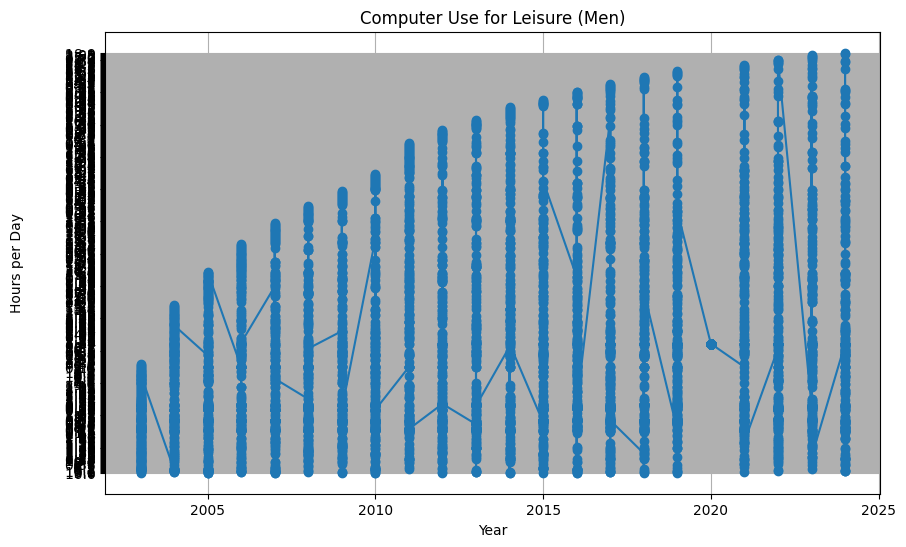

In [202]:
subset = male_use_ready[
    male_use_ready["series_title"].str.contains("Computer use for leisure", case=False, na=False)
]

plt.figure(figsize=(10,6))
plt.plot(subset["year"], subset["value"], marker="o")
plt.title("Computer Use for Leisure (Men)")
plt.xlabel("Year")
plt.ylabel("Hours per Day")
plt.grid(True)
plt.show()

# Search for unique phrase again

In [203]:
male_use_ready["series_title"].unique()

array(['Avg hrs per day - Playing games, Men',
       'Percent participating on an avg day - Telephone calls (to or from), Employed full time, Men',
       'Avg hrs per day - Telephone calls, mail, and e-mail (includes travel), Weekend days and holidays, 65 yrs and over, Men',
       ...,
       'Avg hrs per day - Playing games and computer use for leisure, Nonholiday weekdays, Men',
       'Avg hrs per day - Telephone calls, mail, and e-mail (includes travel), 65-74 yrs, Men',
       'Avg hrs per day - Telephone calls, mail, and e-mail (includes travel), 75 yrs and over, Men'],
      shape=(1098,), dtype=object)

## Decide to keep these terms

In [204]:
keep_keywords = [
    "Avg hrs per day - Playing games, Men",
    "Avg hrs per day - Playing games and computer use for leisure, Nonholiday weekdays, Men",
    "Avg hrs per day - Computer use for leisure, Men",
    "Percent participating on an avg day - Telephone calls (to or from), Men",
    "Avg hrs per day - Telephone calls, mail, and e-mail (includes travel), Men"
]

# Step 2: Filter for these datasets
male_use_filtered = male_use_ready[
    male_use_ready["series_title"].isin(keep_keywords)
].copy()

# Step 3: Filter age groups
male_use_filtered = male_use_filtered[
    ~male_use_filtered["series_title"].str.contains("65", na=False)
]

# Step 4: Sort by year for clarity
male_use_filtered = male_use_filtered.sort_values("year")

# Step 5: Preview
print(male_use_filtered.shape)
display(male_use_filtered.head(20))

(87, 3)


,year,value,series_title
0,2003,0.20,"Avg hrs per day - Playing games, Men"
16838,2003,8.4,Percent participating on an avg day - Telephon...
2024,2003,0.13,"Avg hrs per day - Telephone calls, mail, and e..."
2025,2004,0.11,"Avg hrs per day - Telephone calls, mail, and e..."
16839,2004,10.0,Percent participating on an avg day - Telephon...
3891,2004,0.42,Avg hrs per day - Playing games and computer u...
1,2004,0.23,"Avg hrs per day - Playing games, Men"
2026,2005,0.12,"Avg hrs per day - Telephone calls, mail, and e..."
3892,2005,0.35,Avg hrs per day - Playing games and computer u...
2,2005,0.22,"Avg hrs per day - Playing games, Men"


## Change "Year" column to numbers

In [212]:
male_use_pivot = male_use_filtered.pivot(
    index="year",
    columns="series_title",
    values="value"
).reset_index()

# make sure year is int
male_use_pivot["year"] = male_use_pivot["year"].astype(int)
print(male_use_pivot.dtypes)

series_title
year                                                                                       int64
Avg hrs per day - Playing games and computer use for leisure, Nonholiday weekdays, Men    object
Avg hrs per day - Playing games, Men                                                      object
Avg hrs per day - Telephone calls, mail, and e-mail (includes travel), Men                object
Percent participating on an avg day - Telephone calls (to or from), Men                   object
dtype: object


In [216]:
# Convert all non-year columns to numeric
for col in male_use_pivot.columns:
    if col != "year":
        male_use_pivot[col] = pd.to_numeric(male_use_pivot[col], errors="coerce")

# Check the data types again
print(male_use_pivot.dtypes)

series_title
year                                                                                        int64
Avg hrs per day - Playing games and computer use for leisure, Nonholiday weekdays, Men    float64
Avg hrs per day - Playing games, Men                                                      float64
Avg hrs per day - Telephone calls, mail, and e-mail (includes travel), Men                float64
Percent participating on an avg day - Telephone calls (to or from), Men                   float64
dtype: object


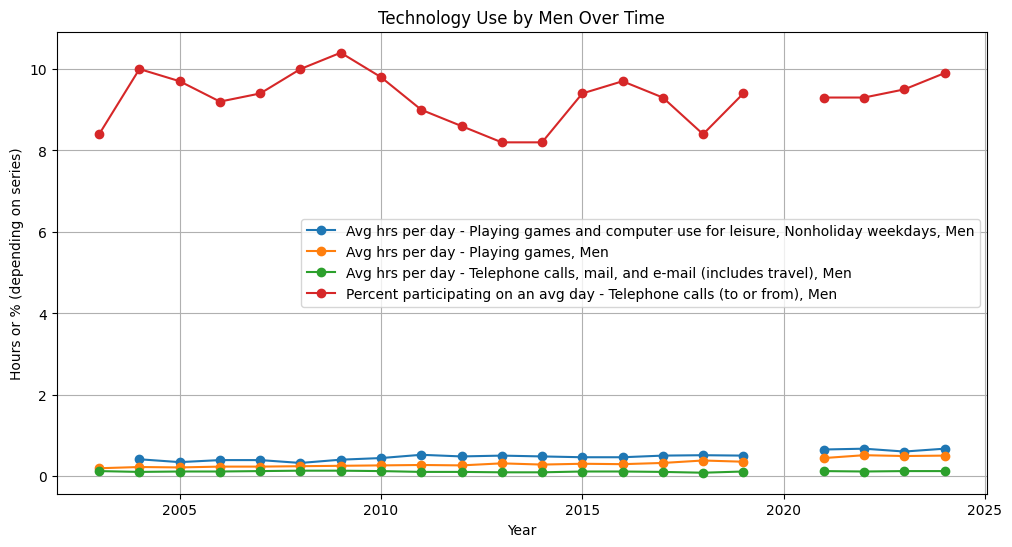

In [217]:
plt.figure(figsize=(12,6))

for col in male_use_pivot.columns[1:]:  # skip 'year'
    plt.plot(male_use_pivot["year"], male_use_pivot[col], marker="o", label=col)

plt.title("Internet and Video Game Use by Men Over Time")
plt.xlabel("Year")
plt.ylabel("Hours or % (depending on series)")
plt.legend()
plt.grid(True)
plt.show()

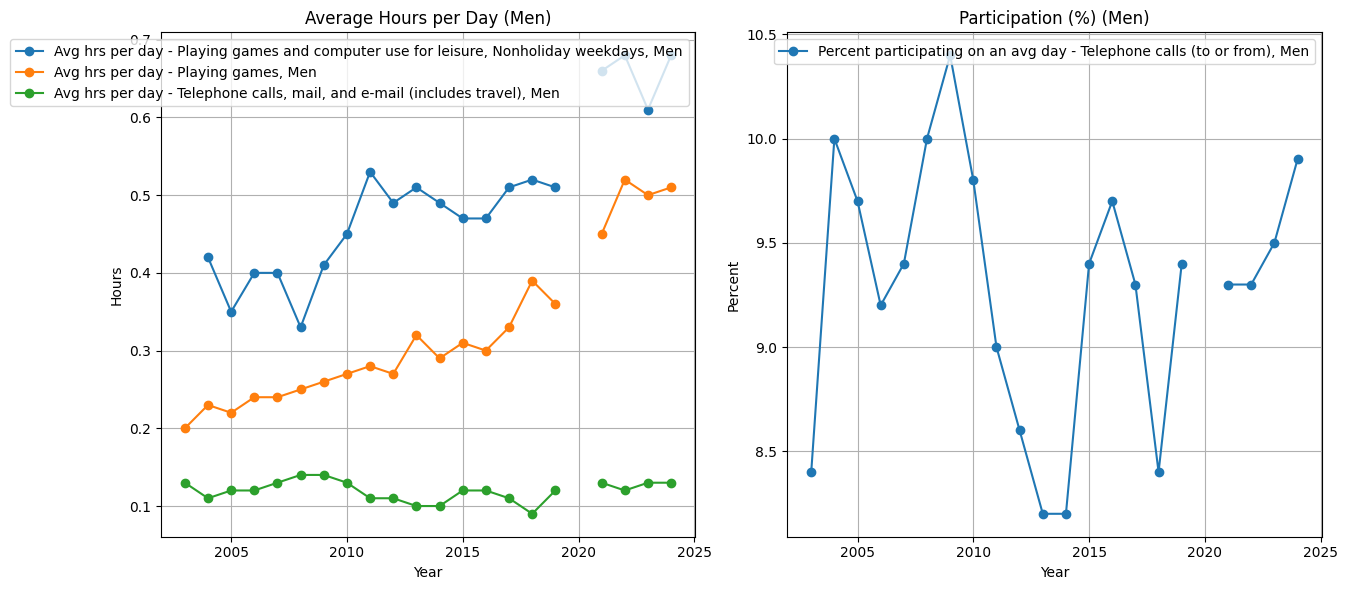

In [220]:
# Split the columns into two groups
hours_cols = [
    "Avg hrs per day - Playing games and computer use for leisure, Nonholiday weekdays, Men",
    "Avg hrs per day - Playing games, Men",
    "Avg hrs per day - Telephone calls, mail, and e-mail (includes travel), Men"
]

percent_cols = [
    "Percent participating on an avg day - Telephone calls (to or from), Men"
]

# Make side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharex=True)

# --- Hours plot ---
for col in hours_cols:
    axes[0].plot(male_use_pivot["year"], male_use_pivot[col], marker="o", label=col)
axes[0].set_title("Average Hours per Day (Men)")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Hours")
axes[0].legend()
axes[0].grid(True)

# --- Percent plot ---
for col in percent_cols:
    axes[1].plot(male_use_pivot["year"], male_use_pivot[col], marker="o", label=col)
axes[1].set_title("Participation (%) (Men)")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Percent")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()